# Классификация светофоров

In [34]:
import cv2
import numpy as np
import zipfile
import skimage as ski
import matplotlib.pyplot as plt
import os
import random
from scipy.signal import find_peaks
import shutil

#### 1. Распаковка zip

In [2]:
# после запуска ячейки все изображения будут в папке dataset, которая в gitignore
zipfile_path = 'tlights.zip'
output_directory = 'dataset'

with zipfile.ZipFile(zipfile_path, 'r') as zf:
    zf.extractall(output_directory)

#### 2. Посмотрим на изображения

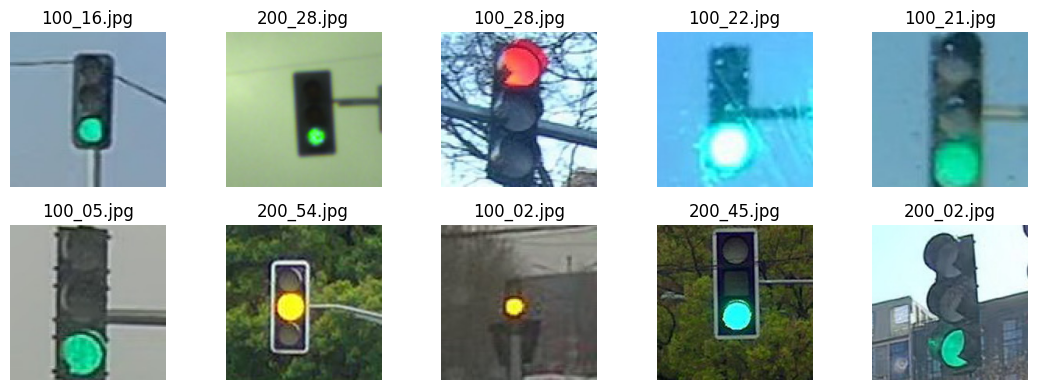

In [3]:
imgs_directory = 'dataset/tlights'
all_imgs = os.listdir(imgs_directory)
random_sample = random.sample(all_imgs, 10)

fig, axes = plt.subplots(nrows=2,
                         ncols=5,
                         figsize=(11, 4))
axes = axes.ravel()

for i, img_name in enumerate(random_sample):
    # подгружаем файлы
    img_path = os.path.join(imgs_directory, img_name)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # визуализация изображения
    axes[i].imshow(img)
    axes[i].set_title(img_name)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

#### 3. Посмотрим на распределение интенсивностей пикселей для каждого цветового канала

Гистограммы цветов могу быть полезны для анализа, т.к. они позволяют увидеть преобладание определенных цветов и их распределение:

* если каналы имеют схожее распределение, то цветовой баланс сбалансирован; если же один из каналов имеет сдвинутый пик, то, возможно, на изображении преобладает этот канал (например, есть пики красного => изображение может быть красноватым)
* если пики гистограммы расположены ближе к левому (темному) или правому (светлому) краю, это может указывать на недостаточную или избыточную яркость/экспозицию.

In [4]:
path_img_green = 'dataset/tlights/100_04.jpg'
path_img_yellow = 'dataset/tlights/200_55.jpg'
path_img_red = 'dataset/tlights/100_36.jpg'

img_green = cv2.imread(path_img_green)
img_green = cv2.cvtColor(img_green, cv2.COLOR_BGR2RGB)

img_red = cv2.imread(path_img_red)
img_red = cv2.cvtColor(img_red, cv2.COLOR_BGR2RGB)

img_yellow = cv2.imread(path_img_yellow)
img_yellow = cv2.cvtColor(img_yellow, cv2.COLOR_BGR2RGB)


def plot_color_channel_histogram(img, title):
    # цветовые каналы
    colors = ("red", "green", "blue")
    plt.figure()
    plt.xlim([0, 256])
    for (channel_id, color) in enumerate(colors):
        histogram, _ = np.histogram(
            img[:, :, channel_id],
            bins=256,
            range=(0, 256)
        )
        plt.plot(histogram, color=color)

    plt.xlabel("color value")
    plt.ylabel("pixel count")
    plt.title(title)


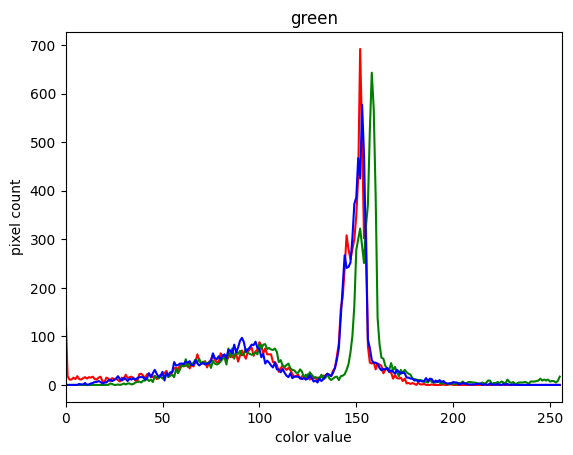

In [5]:
plot_color_channel_histogram(img_green, 'green')

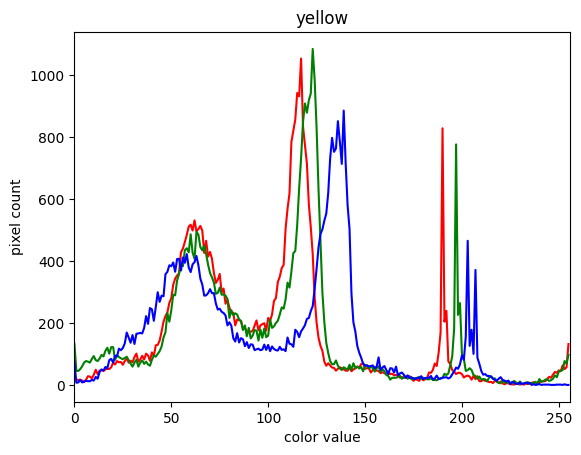

In [6]:
plot_color_channel_histogram(img_yellow, 'yellow')

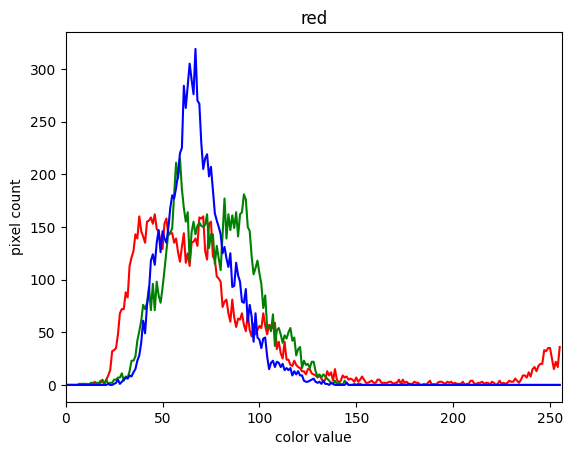

In [7]:
plot_color_channel_histogram(img_red, 'red')

В данном случае цветовой баланс имеет нормально распределен и по гистограмм трудно определить цвет светофора

#### 4. Распределение интенсивностей для области с цветом

Далее выделим область, в котором четко виден цвет светофора, и построим подобные гистограммы. Такой анализ даст возможность получить более точное представление о распределении цветовых каналов в конкретном сегменте изображения

In [8]:
def plot_color_channel_histogram_with_mask(img, mask, title):
    # цветовые каналы
    colors = ("red", "green", "blue")
    plt.figure()
    plt.xlim([0, 256])
    for (channel_id, color) in enumerate(colors):
        histogram, _ = np.histogram(
            img[:, :, channel_id][mask],
            bins=256,
            range=(0, 256)
        )
        plt.plot(histogram, color=color)

    plt.xlabel("color value")
    plt.ylabel("pixel count")
    plt.title(title)

def plot_masked_image(img, center_x, center_y, radius):
    wellplate = np.copy(img);
    mask = np.zeros(shape=wellplate.shape[0:2], dtype="bool")
    circle = ski.draw.disk(center=(center_x, center_y), radius=radius, shape=wellplate.shape[0:2])
    mask[circle] = 1

    masked_img = wellplate[:]
    masked_img[np.logical_not(mask)] = 0
    plt.imshow(masked_img)

    return wellplate, mask

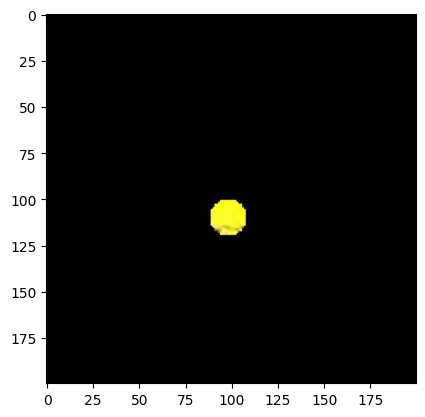

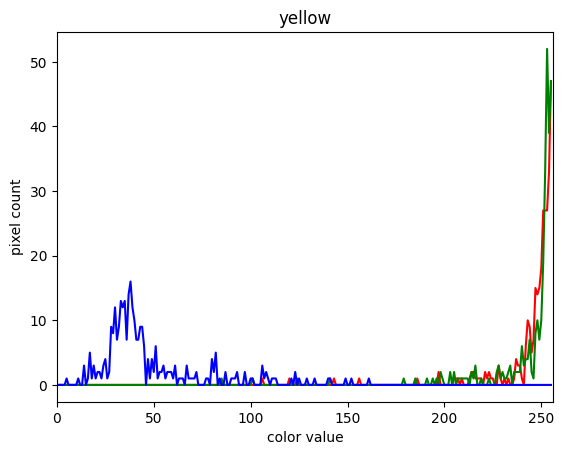

In [9]:
wellplate, mask = plot_masked_image(img_yellow, center_x=110, center_y=98, radius=10)
plot_color_channel_histogram_with_mask(wellplate, mask, 'yellow')

У желтого светофора на сегменте с желтым цветом преобладают зеленый и красный каналы

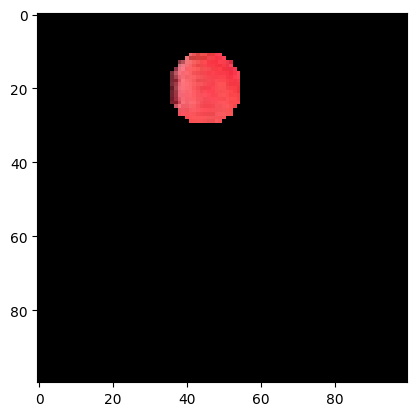

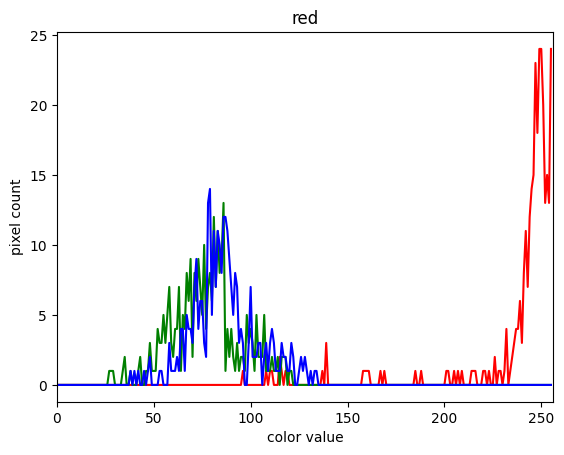

In [10]:
wellplate, mask = plot_masked_image(img_red, center_x=20, center_y=45, radius=10)
plot_color_channel_histogram_with_mask(wellplate, mask, 'red')

У красного светофора на сегмента с красным цветом преобладает красный цвет

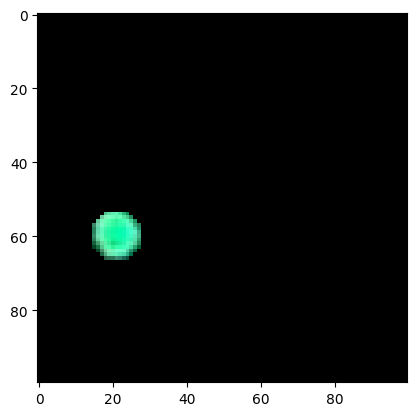

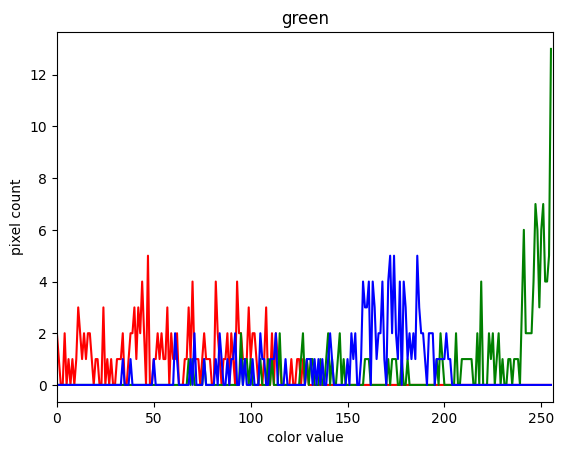

In [11]:
wellplate, mask = plot_masked_image(img_green, center_x=60, center_y=21, radius=7)
plot_color_channel_histogram_with_mask(wellplate, mask, 'green')

У зеленого светофора на сегменте с зелёным цветом преобладает, ожидаемо, зеленый канал

#### 5. Преобразование в HSV
Цветовое пространство HSV более удобно для определение оттенков и последующей классификации, поэтому воспользуемся им

In [12]:
def visualize_hsv(img_rgb):
    img_hsv = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2HSV)

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    ax1.imshow(img_hsv[:,:,0])
    ax1.set_title("Hue")
    ax2.imshow(img_hsv[:,:,1])
    ax2.set_title("Saturation")
    ax3.imshow(img_hsv[:,:,2])
    ax3.set_title("Value")

    plt.figure()
    plt.imshow(img_rgb)
    plt.title("RGB")

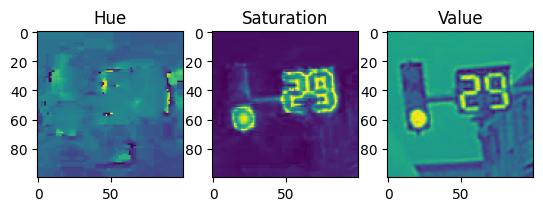

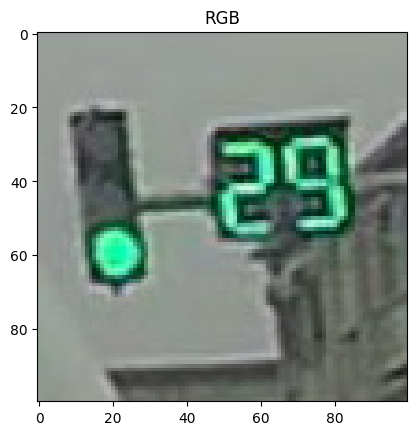

In [13]:
visualize_hsv(img_green)

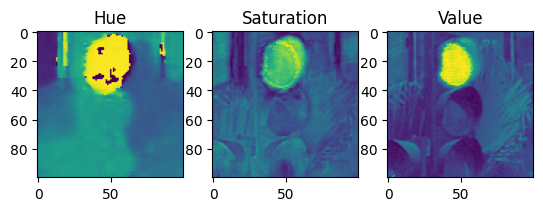

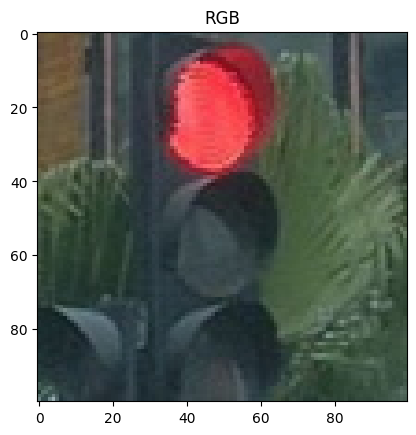

In [14]:
visualize_hsv(img_red)

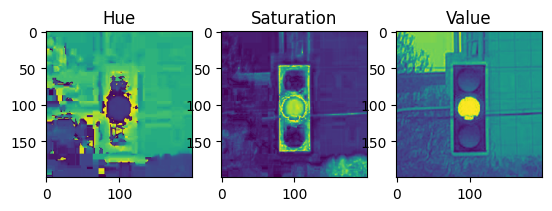

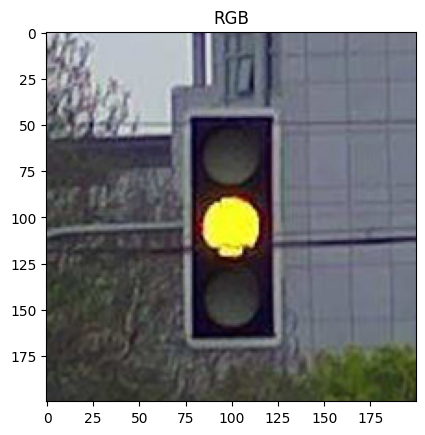

In [15]:
visualize_hsv(img_yellow)

#### 6. Гистограмма для канала Hue

Канал Hue указывает на цветовую тональность / оттенок

Этот параметр будет удобен для классификации

In [44]:
def plot_hue_histogram(img):
    img_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    plt.figure()
    # в opencv для канала hue диапазон равен 180
    plt.xlim([0, 180])
    histogram, _ = np.histogram(
        img_hsv[:, :, 0], bins=180, range=(0, 180)
    )
    plt.plot(histogram)

    peaks, _ = find_peaks(histogram)
    _, sorted_peaks = zip(*sorted(zip(histogram[peaks], peaks), reverse=True))
    # первые 10 пиков
    sorted_peaks = np.asarray(sorted_peaks[:10])
    print('peaks', peaks)
    print('top 10 peaks', sorted_peaks)
    # выделим 10 пиков
    plt.plot(sorted_peaks,histogram[sorted_peaks], "x")

peaks [  6  10  13  17  20  22  24  26  28  30  33  35  37  40  43  46  48  51
  53  57  59  61  63  66  69  72  74  77  81  84  87  90  93  95  98 101
 103 109 115 120 125 128 130 132 135 138 140 145 150 153 156 160 163 170]
top 10 peaks [ 95  98  51 101  69  53  63  90  66  72]


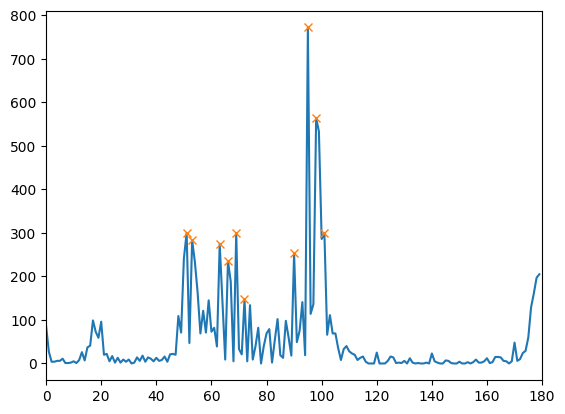

In [45]:
plot_hue_histogram(img_red)

peaks [  6   8  11  13  16  20  24  30  36  38  40  42  45  48  51  55  60  63
  66  70  75  80  83  87  90  93  96  98 101 103 106 110 114 120 126 132
 138 140 145 150 156 158 160 163 165 170 173 177]
top 10 peaks [66 55 60 51 70 80 48 40 75 42]


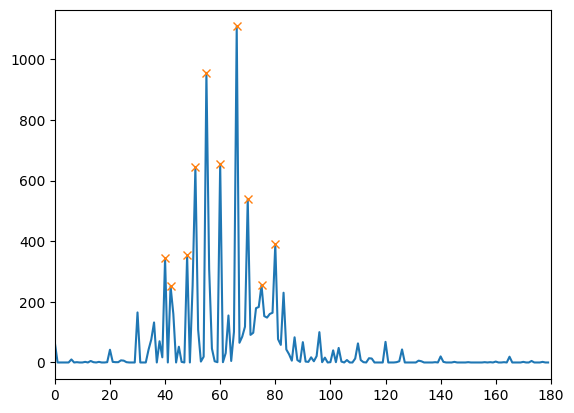

In [46]:
plot_hue_histogram(img_green)

peaks [  2   6   8  11  13  16  21  25  30  36  38  40  42  45  48  50  55  60
  63  66  68  70  73  75  80  83  85  87  90  93  96  98 101 104 106 108
 111 116 118 120 122 125 128 130 132 136 138 141 145 150 153 156 160 165
 170 173 177]
top 10 peaks [111 116 108 125  36  30 106 120 104 118]


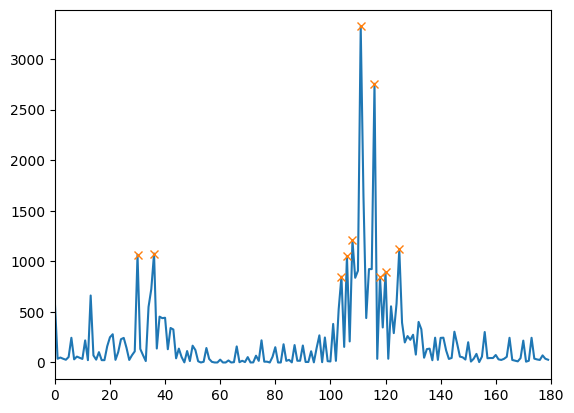

In [47]:
plot_hue_histogram(img_yellow)

- **Красный:** 170-180, 0-10  (https://stackoverflow.com/questions/32522989/opencv-better-detection-of-red-color)
- **Зелёный:** будем варьировать от 30 до 90
- **Желтый:** будем варьировать от 100 до 120 и от 25 до 40


#### 7. Выделение участков с цветом светофора

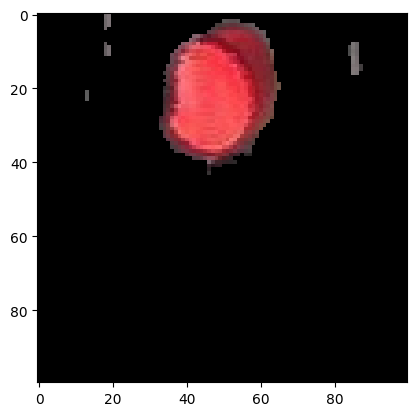

In [ ]:
img = img_red

img_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
wellplate = np.copy(img);
mask = np.zeros(shape=wellplate.shape[0:2], dtype="bool")
x = np.where( ((img_hsv[:,:,0] >= 170) & (img_hsv[:,:,0] <= 180))
              | ((img_hsv[:,:,0] >= 0) & (img_hsv[:,:,0] <= 10)) )
mask[x] = 1

masked_img = wellplate[:]
masked_img[np.logical_not(mask)] = 0
plt.imshow(masked_img)

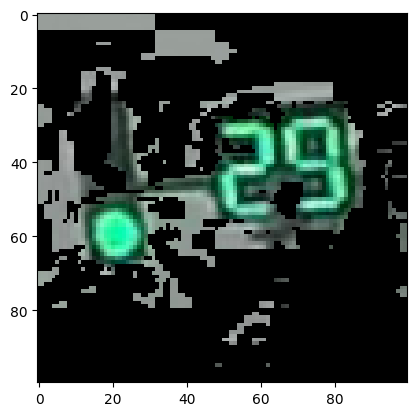

In [70]:
img = img_green

img_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
wellplate = np.copy(img);
mask = np.zeros(shape=wellplate.shape[0:2], dtype="bool")
x = np.where( ((img_hsv[:,:,0] >= 67) & (img_hsv[:,:,0] <= 85)) )
mask[x] = 1

masked_img = wellplate[:]
masked_img[np.logical_not(mask)] = 0
plt.imshow(masked_img)

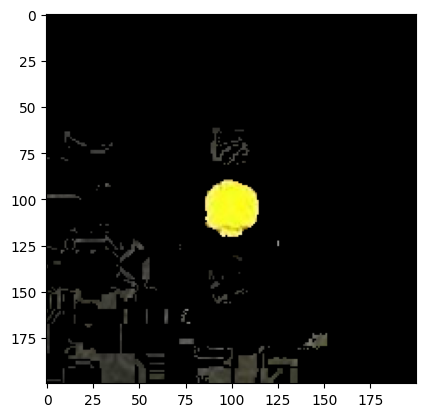

In [95]:
img = img_yellow

img_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
wellplate = np.copy(img);
mask = np.zeros(shape=wellplate.shape[0:2], dtype="bool")
x = np.where( ((img_hsv[:,:,0] >= 23) & (img_hsv[:,:,0] <= 34)))
mask[x] = 1

masked_img = wellplate[:]
masked_img[np.logical_not(mask)] = 0
plt.imshow(masked_img)

#### 8. Классификация изображений (vol 1)

Будем производить классификацию на основе среднего значения канала hue

В прошлом разделе мы получили следующие пороги:
- [23, 34] для жёлтого
- [0, 10] и [170, 180] для красного
- [67, 85] для зелёного

Т.к. будем классифицировать по среднему, то немного расширим границы диапазонов

In [14]:
def classifier(img):
    img_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    mean_hue = np.mean(img_hsv[:, :, 0])

    if 15 <= mean_hue <= 35:
        return 'yellow'
    elif (0 <= mean_hue <= 10) or (160 <= mean_hue <= 180):
        return 'red'
    elif 50 <= mean_hue <= 85:
        return 'green'
    else:
        return 'unclassified'

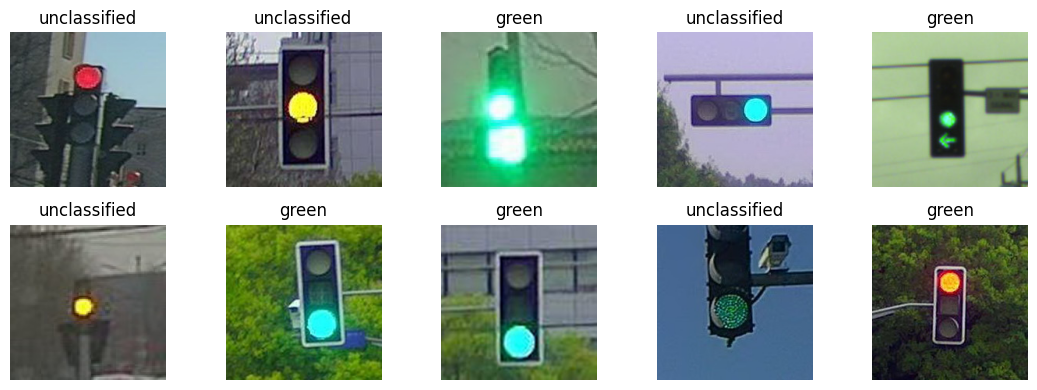

In [16]:
imgs_directory = 'dataset/tlights'
all_imgs = os.listdir(imgs_directory)
random_sample = random.sample(all_imgs, 10)

fig, axes = plt.subplots(nrows=2,
                         ncols=5,
                         figsize=(11, 4))
axes = axes.ravel()

for i, img_name in enumerate(random_sample):
    # подгружаем файлы
    img_path = os.path.join(imgs_directory, img_name)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    predicted_color = classifier(img)
    # визуализация изображения
    axes[i].imshow(img)
    axes[i].set_title(predicted_color)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

#### 9. Классификация изображений (vol 2)

Прошлый подход показал себя не очень. Попробуем заменить подсчет среднего на подсчет суммарного кол-ва пикселей в диапазонах

In [26]:
def classifier_2(img):
    img_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    hue_channel = img_hsv[:, :, 0]

    yellow_range = ((20 <= hue_channel) & (hue_channel <= 35))
    red_range = ((0 <= hue_channel) & (hue_channel <= 10)) | ((160 <= hue_channel) & (hue_channel <= 180))
    green_range = ((63 <= hue_channel) & (hue_channel <= 85))

    # Подсчет пикселей в каждом диапазоне
    yellow_pixels = np.sum(yellow_range)
    red_pixels = np.sum(red_range)
    green_pixels = np.sum(green_range)

    if red_pixels > max(yellow_pixels, green_pixels):
        return 'red'
    elif yellow_pixels > max(red_pixels, green_pixels):
        return 'yellow'
    elif green_pixels > max(yellow_pixels, red_pixels):
        return 'green'
    else:
        return 'unclassified'
    

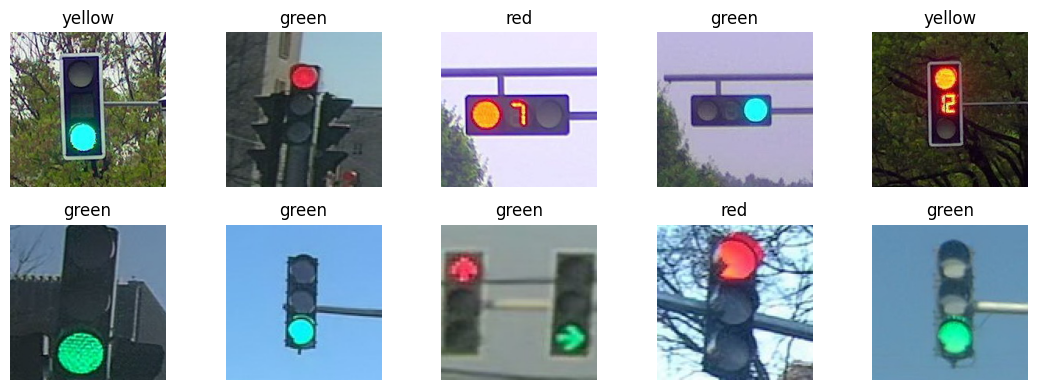

In [27]:
imgs_directory = 'dataset/tlights'
all_imgs = os.listdir(imgs_directory)
random_sample = random.sample(all_imgs, 10)

fig, axes = plt.subplots(nrows=2,
                         ncols=5,
                         figsize=(11, 4))
axes = axes.ravel()

for i, img_name in enumerate(random_sample):
    # подгружаем файлы
    img_path = os.path.join(imgs_directory, img_name)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    predicted_color = classifier_2(img)
    # визуализация изображения
    axes[i].imshow(img)
    axes[i].set_title(predicted_color)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

#### 10. Классификация изображений (vol 3)

Прошлый подход показал приемлемые результаты, но попробуем ещё улучшить с помощью cv2.inRange (https://stackoverflow.com/questions/48109650/how-to-detect-two-different-colors-using-cv2-inrange-in-python-opencv)

In [31]:
red_lower1 = np.array([0, 70, 50])
red_upper1 = np.array([10, 255, 255])
red_lower2 = np.array([170, 70, 50])
red_upper2 = np.array([180, 255, 255])

green_lower = np.array([55, 70, 50])
green_upper = np.array([85, 255, 255])

yellow_lower = np.array([15, 70, 50])
yellow_upper = np.array([35, 255, 255])

def classifier_3(img):
    img_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

    mask_red_1 = cv2.inRange(img_hsv, red_lower1, red_upper1)
    mask_red_2 = cv2.inRange(img_hsv, red_lower2, red_upper2)
    mask_red = cv2.add(mask_red_1, mask_red_2)

    mask_green = cv2.inRange(img_hsv, green_lower, green_upper)
    
    mask_yellow = cv2.inRange(img_hsv, yellow_lower, yellow_upper)

    red_pixels = cv2.countNonZero(mask_red)
    green_pixels = cv2.countNonZero(mask_green)
    yellow_pixels = cv2.countNonZero(mask_yellow)

    if red_pixels > max(yellow_pixels, green_pixels):
        return 'red'
    elif yellow_pixels > max(red_pixels, green_pixels):
        return 'yellow'
    elif green_pixels > max(yellow_pixels, red_pixels):
        return 'green'
    else:
        return 'unclassified'

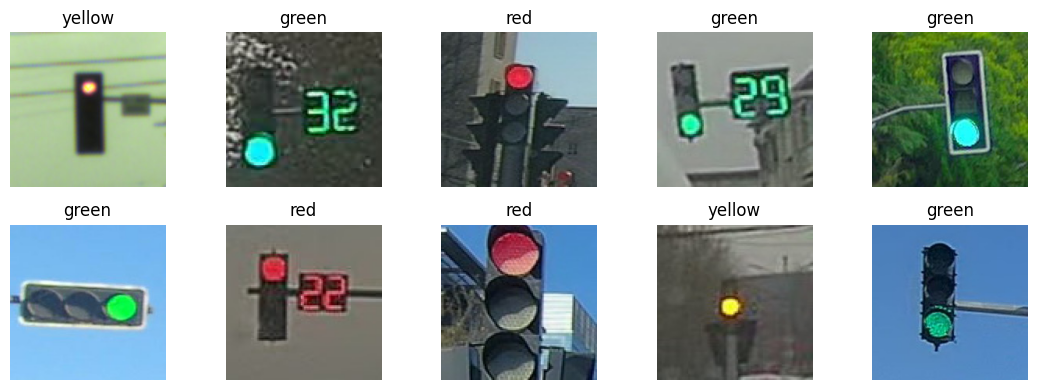

In [32]:
imgs_directory = 'dataset/tlights'
all_imgs = os.listdir(imgs_directory)
random_sample = random.sample(all_imgs, 10)

fig, axes = plt.subplots(nrows=2,
                         ncols=5,
                         figsize=(11, 4))
axes = axes.ravel()

for i, img_name in enumerate(random_sample):
    # подгружаем файлы
    img_path = os.path.join(imgs_directory, img_name)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    predicted_color = classifier_3(img)
    # визуализация изображения
    axes[i].imshow(img)
    axes[i].set_title(predicted_color)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

#### 11. Финальная классификация и распределение по папкам

In [33]:
result_directory = 'result'
os.makedirs(result_directory)

# создание папок для каждой категории
categories = ['red', 'yellow', 'green', 'unclassified']
for category in categories:
    os.makedirs(os.path.join(result_directory, category), exist_ok=True)

In [35]:
imgs_directory = 'dataset/tlights'
all_imgs = os.listdir(imgs_directory)

count_imgs_per_color = {'red': 0,
                        'green': 0,
                        'yellow': 0,
                        'unclassified': 0}

for img_name in all_imgs:
    img_path = os.path.join(imgs_directory, img_name)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    predicted_color = classifier_3(img)
    count_imgs_per_color[predicted_color] += 1

    destination_folder = os.path.join(result_directory, predicted_color)
    destination_path = os.path.join(destination_folder, img_name)

    # Перемещение файла в соответствующую папку
    shutil.copy(img_path, destination_path)

print('Классификация завершена')
print(count_imgs_per_color)

Классификация завершена
{'red': 14, 'green': 52, 'yellow': 32, 'unclassified': 2}
